In [1]:
import os
import pandas as pd
import datetime
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
import numpy as np
import scipy 
import math
import h5py
import time
import copy
import sys
import feather
from sklearn.metrics import mean_absolute_error
from numpy.random import seed
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)
np.set_printoptions(threshold=sys.maxsize)

In [2]:
# set up training set
view_1hot_df = feather.read_dataframe("/home/whsu014/data/view_1hot_nona_len29_float_age_impute_and_True_HG_100096inds.feather")
print(view_1hot_df.columns)
print(view_1hot_df.shape)

print(view_1hot_df['CVD_ISOSORBRIDE_DINITRATE'].unique())
view_1hot_df = view_1hot_df.drop(['CVD_ISOSORBRIDE_DINITRATE'], axis=1)
print("Number of inds:", len(view_1hot_df['VSIMPLE_INDEX_MASTER'].unique()))
# set length to 28
print(view_1hot_df.shape[0]/29)
view_1hot_df = copy.deepcopy(view_1hot_df[view_1hot_df['QUARTER']!=0])
print(view_1hot_df.shape[0]/28)
# Take 90000 inds for train and validation set
# remove true values
# remove QUARTER
view_1hot_df = view_1hot_df.drop(['QUARTER'], axis=1)
view_v = copy.deepcopy(view_1hot_df.iloc[(28*90000):, :].values)
print(view_v.shape)
print(view_v.shape[0]/28)

Index(['VSIMPLE_INDEX_MASTER', 'QUARTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1',
       'ETHN_2', 'ETHN_3', 'ETHN_4', 'ETHN_5',
       ...
       'PT_DIABETES_YR', 'PT_ATRIAL_FIBRILLATION', 'PT_IMP_FATAL_CVD',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL',
       'TRUE_HBA1C', 'TRUE_EGFR'],
      dtype='object', length=191)
(2902784, 191)
[0.]
Number of inds: 100096
100096.0
100096.0
(282688, 189)
10096.0


In [3]:
test_df = feather.read_dataframe("/home/whsu014/data/Test_set_with_TRUE_10096inds.feather")
#lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/TCHDL_GRU_bidirectional_yhat.feather")
gru_yhat_df = feather.read_dataframe("/home/whsu014/data/TCHDL_GRU_yhat.feather")
lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/TCHDL_LSTM_yhat.feather")
#lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/TCHDL_LSTM_04val_yhat.feather")
rnn_yhat_df = feather.read_dataframe("/home/whsu014/data/TCHDL_RNN_yhat.feather")
mlp_yhat_df = feather.read_dataframe("/home/whsu014/data/TCHDL_MLP_yhat.feather")
rr_yhat_df = feather.read_dataframe("/home/whsu014/data/TCHDL_Ridge_Regression_yhat.feather")

print(test_df.shape)
print(gru_yhat_df.shape)
print(lstm_yhat_df.shape)
print(rnn_yhat_df.shape)
print(mlp_yhat_df.shape)
print(rr_yhat_df.shape)
print("Number of inds:", len(test_df['VSIMPLE_INDEX_MASTER'].unique()))

(282688, 189)
(282688, 182)
(282688, 182)
(282688, 182)
(282688, 182)
(282688, 182)
Number of inds: 10096


In [4]:
print("TEST:", test_df.columns.get_loc('TEST'))
print("TCHDL:", test_df.columns.get_loc('TCHDL'))
print("TRUE_TCHDL:", test_df.columns.get_loc('TRUE_TCHDL'))

TEST: 9
TCHDL: 14
TRUE_TCHDL: 186


In [5]:
test_v = copy.deepcopy(test_df.values)
gru_yhat_v = copy.deepcopy(gru_yhat_df.iloc[:, :15].values)
lstm_yhat_v = copy.deepcopy(lstm_yhat_df.iloc[:, :15].values)
rnn_yhat_v = copy.deepcopy(rnn_yhat_df.iloc[:, :15].values)
mlp_yhat_v = copy.deepcopy(mlp_yhat_df.iloc[:, :15].values)
rr_yhat_v = copy.deepcopy(rr_yhat_df.iloc[:, :15].values)
print(test_v.shape)
print(lstm_yhat_v.shape)
print(gru_yhat_v.shape)
print(rnn_yhat_v.shape)
print(mlp_yhat_v.shape)
print(rr_yhat_v.shape)

(282688, 189)
(282688, 15)
(282688, 15)
(282688, 15)
(282688, 15)
(282688, 15)


In [6]:
print(np.unique(test_v[:, 9]))
print(np.array_equal(lstm_yhat_v[:, 0], test_v[:, 0]))
print(lstm_yhat_v[:30, 0])
print(test_v[:30, 0])

[0 1]
False
[75768. 75768. 75768. 75768. 75768. 75768. 75768. 75768. 75768. 75768.
 75768. 75768. 75768. 75768. 75768. 75768. 75768. 75768. 75768. 75768.
 75768. 75768. 75768. 75768. 75768. 75768. 75768. 75768.   786.   786.]
[75768.0 75768.0 75768.0 75768.0 75768.0 75768.0 75768.0 75768.0 75768.0
 75768.0 75768.0 75768.0 75768.0 75768.0 75768.0 75768.0 75768.0 75768.0
 75768.0 75768.0 75768.0 75768.0 75768.0 75768.0 75768.0 75768.0 75768.0
 75768.0 786.0 786.0]


In [7]:

print("TCHDL:", view_1hot_df.columns.get_loc('TCHDL'))
print(view_1hot_df.shape)


TCHDL: 14
(2802688, 189)


In [8]:
#######################################
# Error calculation
#######################################
value_indicating_test = max(np.unique(test_v[:, 9]))
value_indicating_no_test = min(np.unique(test_v[:, 9]))

empty_list_count = 0
empty_list_IDs = []

rmse_interp_list = []
rmse_exterp_list = []
rmse_lstm_list = []
rmse_rnn_list = []
rmse_mlp_list = []
rmse_rr_list = []

mae_interp_list = []
mae_exterp_list = []
mae_lstm_list = []
mae_rnn_list = []
mae_mlp_list = []
mae_rr_list = []

num_of_inds = test_v.shape[0]//28
print("Number of inds:", num_of_inds)

for i in range(num_of_inds):
    ind_id = test_v[i*28, 0]#view_v[i*28, 0]
    ind_y_v = view_v[(i*28):((i+1)*28), :]
    ind_exp_v = test_v[(i*28):((i+1)*28), :]
    ind_lstm_yhat_v = lstm_yhat_v[(i*28):((i+1)*28), :]
    ind_rnn_yhat_v = rnn_yhat_v[(i*28):((i+1)*28), :]
    ind_mlp_yhat_v = mlp_yhat_v[(i*28):((i+1)*28), :]
    ind_rr_yhat_v = rr_yhat_v[(i*28):((i+1)*28), :]
    
    ind_TCHDL_list = []
    ind_interp_list = []
    ind_exterp_list = []
    ind_lstm_list = []
    ind_rnn_list = []
    ind_mlp_list = []
    ind_rr_list = []
    for j in range(8, 28):
        #if ind_y_v[j, 9] == value_indicating_test:
        if len(ind_y_v[j, 186]) > 2:
            TCHDLs = [float(TCHDL) for TCHDL in ind_y_v[j, 186][1:-1].split(", ")]
            mean_TCHDL = sum(TCHDLs)/len(TCHDLs)
            ind_TCHDL_list.append(mean_TCHDL)
            ind_interp_list.append(ind_y_v[j, 14])
            ind_exterp_list.append(ind_exp_v[j, 14])
            ind_lstm_list.append(ind_lstm_yhat_v[j, 14])
            ind_rnn_list.append(ind_rnn_yhat_v[j, 14])
            ind_mlp_list.append(ind_mlp_yhat_v[j, 14])
            ind_rr_list.append(ind_rr_yhat_v[j, 14])
        else:
            empty_list_count += 1
            empty_list_IDs.append(ind_id)
    # case rmse
    ind_rmse_interp = math.sqrt(mean_squared_error(ind_TCHDL_list, ind_interp_list))   
    ind_rmse_exterp = math.sqrt(mean_squared_error(ind_TCHDL_list, ind_exterp_list))
    ind_rmse_lstm = math.sqrt(mean_squared_error(ind_TCHDL_list, ind_lstm_list))
    ind_rmse_rnn = math.sqrt(mean_squared_error(ind_TCHDL_list, ind_rnn_list))
    ind_rmse_mlp = math.sqrt(mean_squared_error(ind_TCHDL_list, ind_mlp_list))
    ind_rmse_rr = math.sqrt(mean_squared_error(ind_TCHDL_list, ind_rr_list))
    # case mae
    ind_mae_interp = mean_absolute_error(ind_TCHDL_list, ind_interp_list)
    ind_mae_exterp = mean_absolute_error(ind_TCHDL_list, ind_exterp_list)
    ind_mae_lstm = mean_absolute_error(ind_TCHDL_list, ind_lstm_list)
    ind_mae_rnn = mean_absolute_error(ind_TCHDL_list, ind_rnn_list)
    ind_mae_mlp = mean_absolute_error(ind_TCHDL_list, ind_mlp_list)
    ind_mae_rr = mean_absolute_error(ind_TCHDL_list, ind_rr_list)
    
    rmse_interp_list.append(ind_rmse_interp)
    rmse_exterp_list.append(ind_rmse_exterp)
    rmse_lstm_list.append(ind_rmse_lstm)
    rmse_rnn_list.append(ind_rmse_rnn)
    rmse_mlp_list.append(ind_rmse_mlp)
    rmse_rr_list.append(ind_rmse_rr)

    mae_interp_list.append(ind_mae_interp)
    mae_exterp_list.append(ind_mae_exterp)
    mae_lstm_list.append(ind_mae_lstm)
    mae_rnn_list.append(ind_mae_rnn)
    mae_mlp_list.append(ind_mae_mlp)
    mae_rr_list.append(ind_mae_rr)
    
print(empty_list_count)
#print(empty_list_IDs)

print(len(rmse_interp_list))
print(len(rmse_exterp_list))
print(len(rmse_lstm_list))
print(len(rmse_rnn_list))
print(len(rmse_mlp_list))
print(len(rmse_rr_list))

print(len(mae_interp_list))
print(len(mae_exterp_list))
print(len(mae_lstm_list))
print(len(mae_rnn_list))
print(len(mae_mlp_list))
print(len(mae_rr_list))

print("RMSE Interp:\t", np.mean(rmse_interp_list))
print("RMSE Exterp:\t", np.mean(rmse_exterp_list))
print("RMSE LSTM:\t", np.mean(rmse_lstm_list))
print("RMSE RNN:\t", np.mean(rmse_rnn_list))
print("RMSE MLP:\t", np.mean(rmse_mlp_list))    
print("RMSE RR:\t", np.mean(rmse_rr_list))    

print("MAE Interp:\t", np.mean(mae_interp_list))
print("MAE Exterp:\t", np.mean(mae_exterp_list))
print("MAE LSTM:\t", np.mean(mae_lstm_list))
print("MAE RNN:\t", np.mean(mae_rnn_list))
print("MAE MLP:\t", np.mean(mae_mlp_list))         
print("MAE RR:\t\t", np.mean(mae_rr_list))         

Number of inds: 10096
139648
10096
10096
10096
10096
10096
10096
10096
10096
10096
10096
10096
10096
RMSE Interp:	 0.17662063160331065
RMSE Exterp:	 0.8127340583988681
RMSE LSTM:	 0.7060933334273491
RMSE RNN:	 0.6997968952323724
RMSE MLP:	 0.698808118277145
RMSE RR:	 0.704374888720161
MAE Interp:	 0.1224147945871851
MAE Exterp:	 0.7179975227170701
MAE LSTM:	 0.611978861985037
MAE RNN:	 0.6052539239710247
MAE MLP:	 0.6052471801762574
MAE RR:		 0.6125186015997773


(array([ 70., 165., 353., 593., 793., 798., 812., 749., 700., 644., 560.,
        493., 446., 411., 314., 289., 298., 237., 196., 191., 166., 123.,
         92.,  97.,  66.,  68.,  53.,  41.,  36.,  33.,  31.,  28.,  21.,
         16.,  16.,  13.,   7.,   5.,   6.,   6.,   3.,   7.,   6.,   4.,
          5.,   2.,   3.,   4.,   0.,   3.,   0.,   1.,   2.,   1.,   2.,
          2.,   0.,   3.,   2.,   1.,   2.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   2.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          1.]),
 array([2.43443526e-03, 6.78026409e-02, 1.33170847e-01, 1.98539052e-01,
        2.63907258e-01, 3.29275463e-01, 3.94643669e-01, 4.60011875e-01,
        5.25380080e-01, 5.90748286e-01, 6.56116492e-01, 7.21484697e-01,
        7.86852903e-01, 8.52221109e-01, 9.17589314e-01, 9.82957520e-01,
        1.04832573e+00, 1.1136

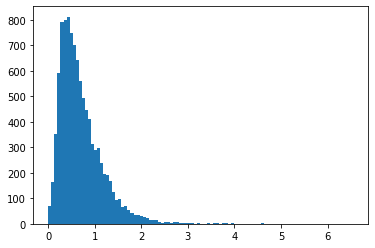

In [10]:
pyplot.hist(rmse_lstm_list, bins = 100)

In [ ]:
GRU
RMSE Interp:	 0.17662063160331065
RMSE Exterp:	 0.8127340583988681
RMSE GRU:	 0.7026665813620571
RMSE RNN:	 0.6997968952323724
RMSE MLP:	 0.698808118277145
RMSE RR:	 0.704374888720161
MAE Interp:	 0.1224147945871851
MAE Exterp:	 0.7179975227170701
MAE GRU:	 0.6084454696591313
MAE RNN:	 0.6052539239710247
MAE MLP:	 0.6052471801762574
MAE RR:		 0.6125186015997773

## Quarter by quarter  error

In [13]:
results_list = [[[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
                [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
                [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
                [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
                [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]]

In [14]:
num_of_inds = test_v.shape[0]//28
print("Number of inds:", num_of_inds)

# results_v - lstm, gru, rnn, mlp, rr
for i in range(num_of_inds):
    ind_id = view_v[i*28, 0]
    ind_y_v = view_v[(i*28):((i+1)*28), :]
    ind_exp_v = test_v[(i*28):((i+1)*28), :]
    ind_lstm_yhat_v = lstm_yhat_v[(i*28):((i+1)*28), :]
    ind_gru_yhat_v = gru_yhat_v[(i*28):((i+1)*28), :]
    ind_rnn_yhat_v = rnn_yhat_v[(i*28):((i+1)*28), :]
    ind_mlp_yhat_v = mlp_yhat_v[(i*28):((i+1)*28), :]
    ind_rr_yhat_v = rr_yhat_v[(i*28):((i+1)*28), :]
    
    for j in range(8, 28):
        #if ind_y_v[j, 9] == value_indicating_test:
        if len(ind_y_v[j, 186]) > 2:
            TCHDLs = [float(TCHDL) for TCHDL in ind_y_v[j, 186][1:-1].split(", ")]
            mean_TCHDL = sum(TCHDLs)/len(TCHDLs)

            results_list[0][j-8].append((ind_lstm_yhat_v[j, 14] - mean_TCHDL)) 
            results_list[1][j-8].append((ind_gru_yhat_v[j, 14] - mean_TCHDL))
            results_list[2][j-8].append((ind_rnn_yhat_v[j, 14] - mean_TCHDL))
            results_list[3][j-8].append((ind_mlp_yhat_v[j, 14] - mean_TCHDL))
            results_list[4][j-8].append((ind_rr_yhat_v[j, 14] - mean_TCHDL))
        else:
            empty_list_count += 1
            empty_list_IDs.append(ind_id)

Number of inds: 10096


In [32]:
model_dict = {0:"LSTM", 1:"GRU", 2:"RNN", 3:"MLP", 4:"RR"}
for i in range(5):
    print(model_dict[i])
    for j in range(20):
        #print("QUARTER " + str((j+1)) + 
        #      "\t" + str(len(results_list[i][j])))
        mae = np.mean(np.absolute(results_list[i][j]))
        rmse = np.sqrt(np.mean(np.power(results_list[i][j], 2)))
        print("QUARTER " + str(j+1) + "\t" +
              "MAE: %0.5f \t RMSE: %0.5f" % (mae, rmse))
    print("###############################################")

LSTM
QUARTER 1	MAE: 0.62545 	 RMSE: 0.87554
QUARTER 2	MAE: 0.60212 	 RMSE: 0.86183
QUARTER 3	MAE: 0.58806 	 RMSE: 0.82344
QUARTER 4	MAE: 0.59746 	 RMSE: 0.83898
QUARTER 5	MAE: 0.59162 	 RMSE: 0.82456
QUARTER 6	MAE: 0.59778 	 RMSE: 0.82119
QUARTER 7	MAE: 0.61062 	 RMSE: 0.84924
QUARTER 8	MAE: 0.60862 	 RMSE: 0.82655
QUARTER 9	MAE: 0.60998 	 RMSE: 0.83878
QUARTER 10	MAE: 0.61519 	 RMSE: 0.84051
QUARTER 11	MAE: 0.59796 	 RMSE: 0.84778
QUARTER 12	MAE: 0.61891 	 RMSE: 0.89235
QUARTER 13	MAE: 0.62808 	 RMSE: 0.86703
QUARTER 14	MAE: 0.62126 	 RMSE: 0.84178
QUARTER 15	MAE: 0.61167 	 RMSE: 0.84268
QUARTER 16	MAE: 0.62960 	 RMSE: 0.96697
QUARTER 17	MAE: 0.62665 	 RMSE: 0.86635
QUARTER 18	MAE: 0.64720 	 RMSE: 0.90031
QUARTER 19	MAE: 0.60972 	 RMSE: 0.83135
QUARTER 20	MAE: 0.63129 	 RMSE: 0.87043
###############################################
GRU
QUARTER 1	MAE: 0.63203 	 RMSE: 0.88690
QUARTER 2	MAE: 0.59899 	 RMSE: 0.85736
QUARTER 3	MAE: 0.58659 	 RMSE: 0.82023
QUARTER 4	MAE: 0.59170 	 RMSE: 0.82